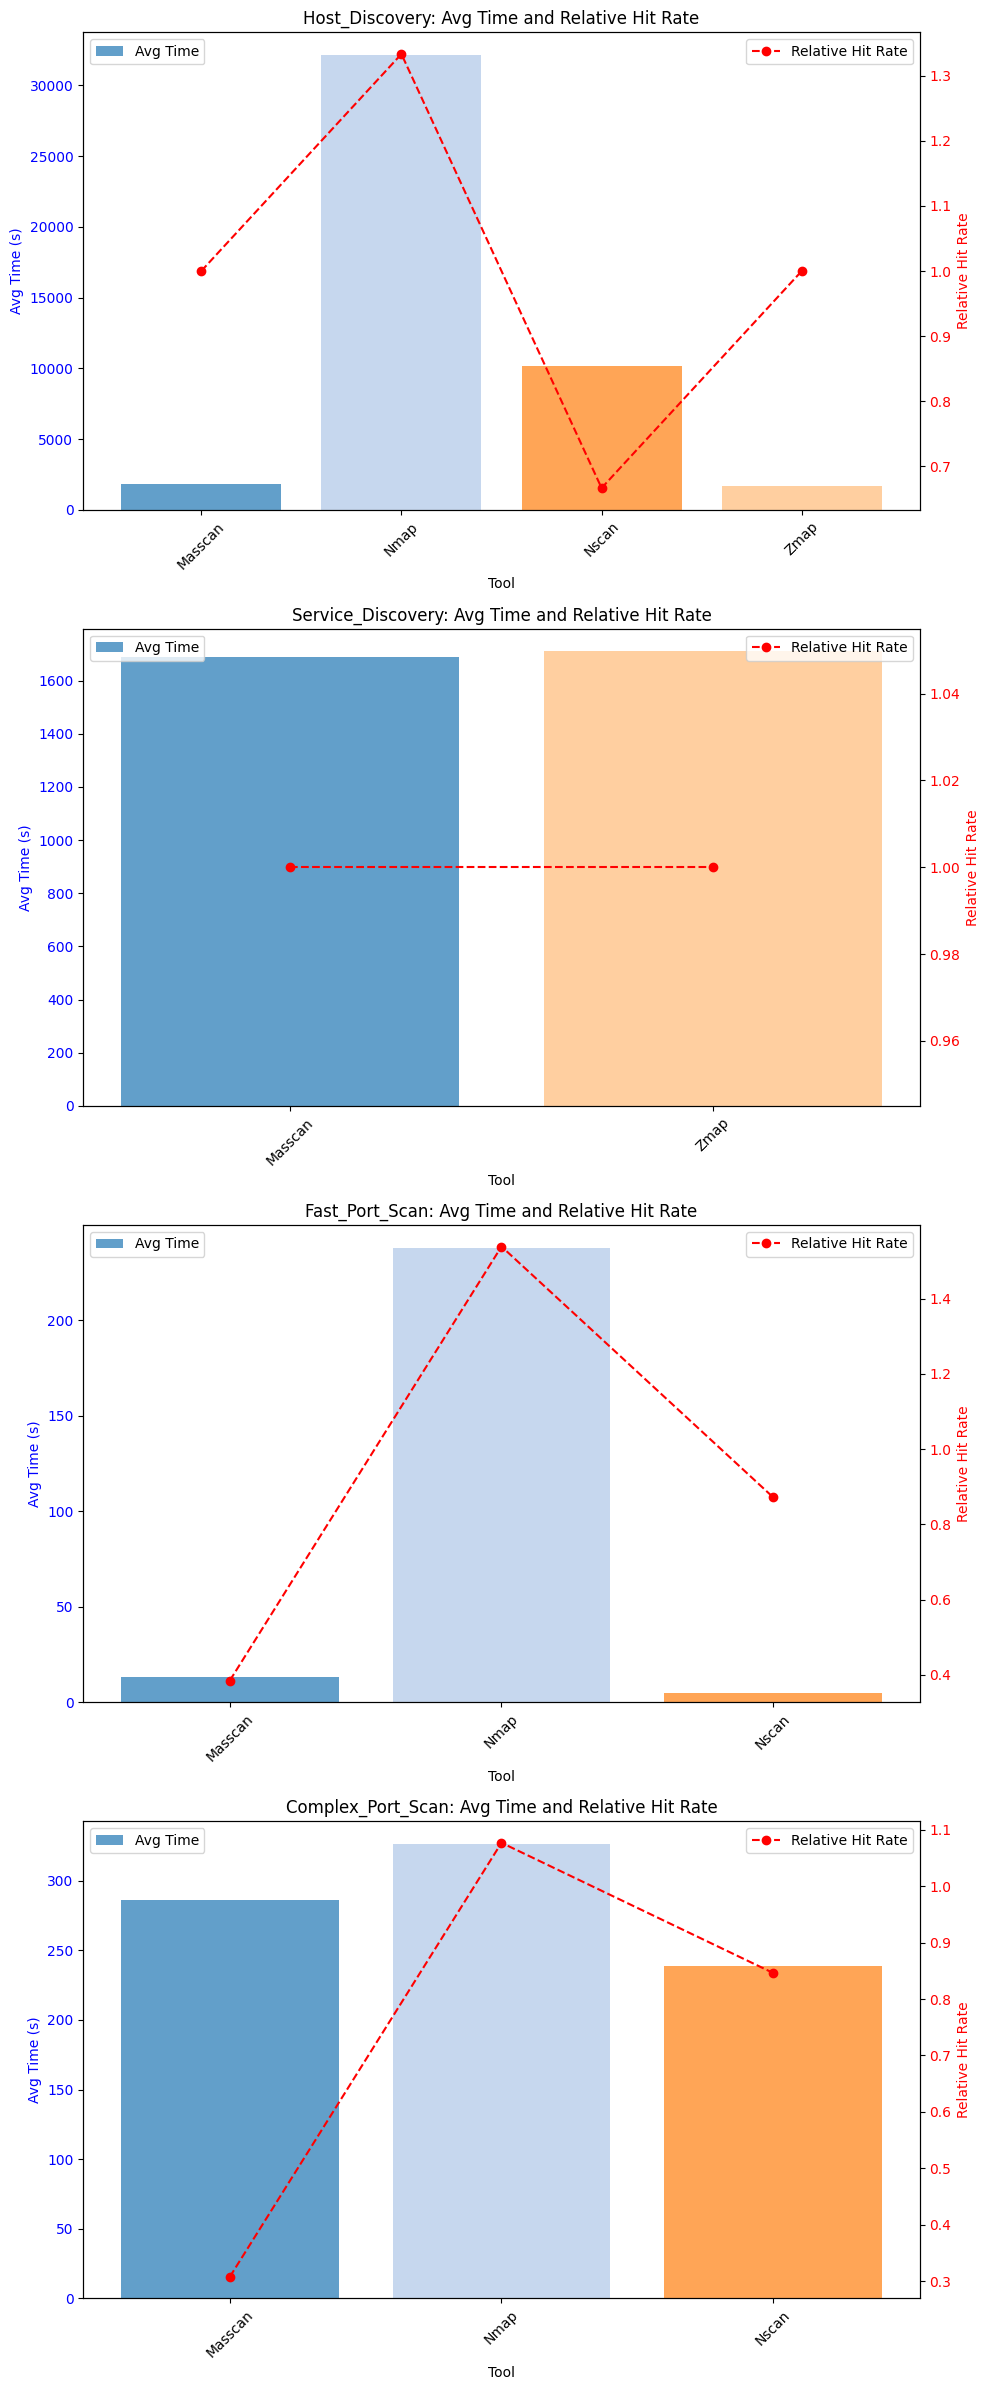

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from statistics import median
import re

with open('data.json') as f:
    data = json.load(f)

def time_to_seconds(time_str):
    minutes, seconds = map(float, re.findall(r'(\d+)m(\d+\.\d+)s', time_str)[0])
    return minutes * 60 + seconds

def process_data(data):
    results = {}
    tools = set()

    for scan_type, scans in data.items():
        df = pd.DataFrame(scans)
        df['Time'] = df['Time'].apply(time_to_seconds)

        median_hit_rate = median(df['Hit_Rate'].dropna())
        df['Relative_Hit_Rate'] = df['Hit_Rate'] / median_hit_rate

        avg_results = df.groupby('Tool').agg({
            'Time': 'mean', 
            'Hit_Rate': 'mean', 
            'Relative_Hit_Rate': 'mean'
        }).reset_index()
        
        tools.update(avg_results['Tool'].unique())
        results[scan_type] = avg_results

    return results, tools

def plot_data(processed_data, tool_colors):
    _, axes = plt.subplots(nrows=len(processed_data), ncols=1, figsize=(10, 6 * len(processed_data)))
    axes = [axes] if len(processed_data) == 1 else axes

    for ax, (scan_type, df) in zip(axes, processed_data.items()):
        ax.bar(df['Tool'], df['Time'], color=[tool_colors[tool] for tool in df['Tool']], alpha=0.7)
        ax.set_title(f'{scan_type}: Avg Time and Relative Hit Rate')
        ax.set_xlabel('Tool')
        ax.set_ylabel('Avg Time (s)', color='blue')
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', labelcolor='blue')

        ax2 = ax.twinx()
        ax2.plot(df['Tool'], df['Relative_Hit_Rate'], color='red', marker='o', linestyle='--', label='Relative Hit Rate')
        ax2.set_ylabel('Relative Hit Rate', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        ax.legend(['Avg Time'], loc='upper left')
        ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

processed_data, unique_tools = process_data(data)
tool_colors = {tool: plt.cm.tab20.colors[idx % 20] for idx, tool in enumerate(sorted(unique_tools))}
plot_data(processed_data, tool_colors)